<a href="https://colab.research.google.com/github/Parth-Rawri/Generating-Anime-Images-using-DCGAN/blob/main/Generating_Anime_Images_using_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading and Exploring the Data

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

  0%|          | 0.00/395M [00:00<?, ?B/s]

100%|██████████| 395M/395M [00:05<00:00, 78.3MB/s]


In [ ]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['33316_2011.jpg', '61094_2018.jpg', '39046_2012.jpg', '50364_2015.jpg', '12764_2005.jpg', '34223_2011.jpg', '35118_2011.jpg', '26982_2009.jpg', '16817_2007.jpg', '22386_2008.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


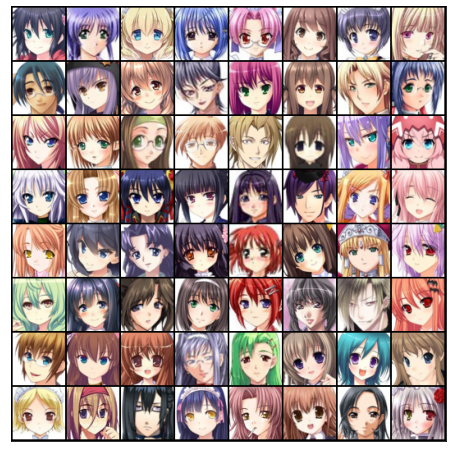

In [ ]:
show_batch(train_dl)

### Using a GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## GAN Model


### Discriminator Network

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

### Generator Network

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


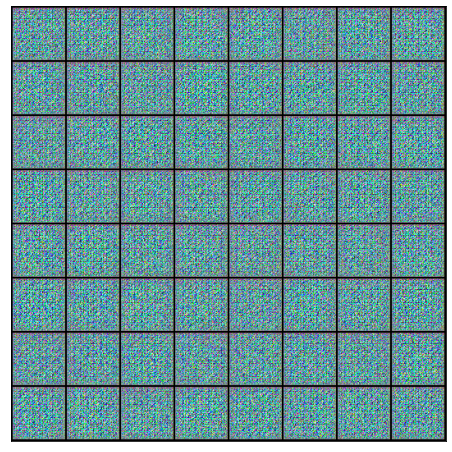

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

In [ ]:
generator = to_device(generator, device)

## Training

### Discriminator Training

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Generator Training

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

Let's create a directory where we can save intermediate outputs from the generator to visually inspect the progress of the model.

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


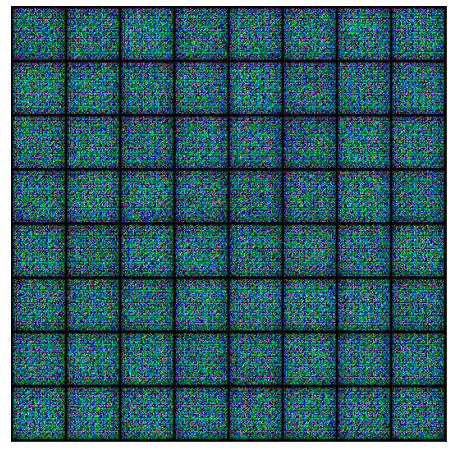

In [ ]:
save_samples(0, fixed_latent)

## Training Loop

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 30

In [ ]:
%%time
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/30], loss_g: 3.9467, loss_d: 0.7491, real_score: 0.5575, fake_score: 0.0300
Saving generated-images-0001.png



Epoch [2/30], loss_g: 5.0804, loss_d: 0.2355, real_score: 0.8903, fake_score: 0.0955
Saving generated-images-0002.png



Epoch [3/30], loss_g: 5.3209, loss_d: 0.2595, real_score: 0.8762, fake_score: 0.1048
Saving generated-images-0003.png



Epoch [4/30], loss_g: 4.4000, loss_d: 0.2181, real_score: 0.9767, fake_score: 0.1633
Saving generated-images-0004.png



Epoch [5/30], loss_g: 5.2412, loss_d: 0.2006, real_score: 0.9477, fake_score: 0.1208
Saving generated-images-0005.png



Epoch [6/30], loss_g: 5.3885, loss_d: 0.1322, real_score: 0.9057, fake_score: 0.0113
Saving generated-images-0006.png



Epoch [7/30], loss_g: 5.2171, loss_d: 0.1372, real_score: 0.9298, fake_score: 0.0502
Saving generated-images-0007.png



Epoch [8/30], loss_g: 4.0330, loss_d: 0.1199, real_score: 0.9476, fake_score: 0.0573
Saving generated-images-0008.png



Epoch [9/30], loss_g: 4.9109, loss_d: 0.1373, real_score: 0.9514, fake_score: 0.0716
Saving generated-images-0009.png



Epoch [10/30], loss_g: 5.2871, loss_d: 0.1377, real_score: 0.9300, fake_score: 0.0490
Saving generated-images-0010.png



Epoch [11/30], loss_g: 5.8912, loss_d: 0.2122, real_score: 0.9286, fake_score: 0.1034
Saving generated-images-0011.png



Epoch [12/30], loss_g: 5.4421, loss_d: 0.1043, real_score: 0.9676, fake_score: 0.0630
Saving generated-images-0012.png



Epoch [13/30], loss_g: 5.7532, loss_d: 0.1127, real_score: 0.9538, fake_score: 0.0573
Saving generated-images-0013.png



Epoch [14/30], loss_g: 4.7037, loss_d: 0.0844, real_score: 0.9649, fake_score: 0.0434
Saving generated-images-0014.png



Epoch [15/30], loss_g: 4.1891, loss_d: 0.1387, real_score: 0.9100, fake_score: 0.0189
Saving generated-images-0015.png



Epoch [16/30], loss_g: 5.1059, loss_d: 0.1216, real_score: 0.9525, fake_score: 0.0626
Saving generated-images-0016.png



Epoch [17/30], loss_g: 3.9865, loss_d: 0.8299, real_score: 0.5684, fake_score: 0.0023
Saving generated-images-0017.png



Epoch [18/30], loss_g: 6.6370, loss_d: 0.1493, real_score: 0.9830, fake_score: 0.1133
Saving generated-images-0018.png



Epoch [19/30], loss_g: 4.8948, loss_d: 0.0949, real_score: 0.9496, fake_score: 0.0267
Saving generated-images-0019.png



Epoch [20/30], loss_g: 4.0014, loss_d: 0.1285, real_score: 0.9323, fake_score: 0.0430
Saving generated-images-0020.png



Epoch [21/30], loss_g: 10.5453, loss_d: 0.2937, real_score: 0.7954, fake_score: 0.0003
Saving generated-images-0021.png



Epoch [22/30], loss_g: 7.6304, loss_d: 0.3660, real_score: 0.9635, fake_score: 0.2376
Saving generated-images-0022.png



Epoch [23/30], loss_g: 4.8833, loss_d: 0.0922, real_score: 0.9651, fake_score: 0.0468
Saving generated-images-0023.png



Epoch [24/30], loss_g: 5.4636, loss_d: 0.0311, real_score: 0.9832, fake_score: 0.0130
Saving generated-images-0024.png



Epoch [25/30], loss_g: 6.5936, loss_d: 0.1278, real_score: 0.9871, fake_score: 0.0988
Saving generated-images-0025.png



Epoch [26/30], loss_g: 3.6023, loss_d: 0.1310, real_score: 0.9127, fake_score: 0.0279
Saving generated-images-0026.png



Epoch [27/30], loss_g: 6.9757, loss_d: 0.1798, real_score: 0.9804, fake_score: 0.1252
Saving generated-images-0027.png



Epoch [28/30], loss_g: 4.9567, loss_d: 0.0873, real_score: 0.9335, fake_score: 0.0115
Saving generated-images-0028.png



Epoch [29/30], loss_g: 5.2375, loss_d: 0.1447, real_score: 0.8822, fake_score: 0.0036
Saving generated-images-0029.png



Epoch [30/30], loss_g: 4.5070, loss_d: 0.1506, real_score: 0.8848, fake_score: 0.0039
Saving generated-images-0030.png
CPU times: user 24min 29s, sys: 52.7 s, total: 25min 21s
Wall time: 31min 38s


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

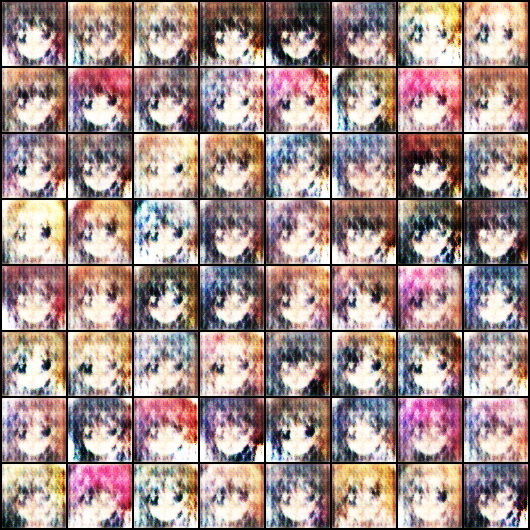

In [ ]:
Image('./generated/generated-images-0001.png')

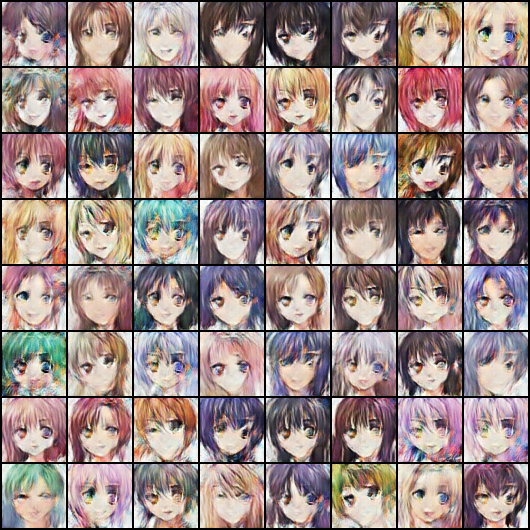

In [ ]:
Image('./generated/generated-images-0010.png')

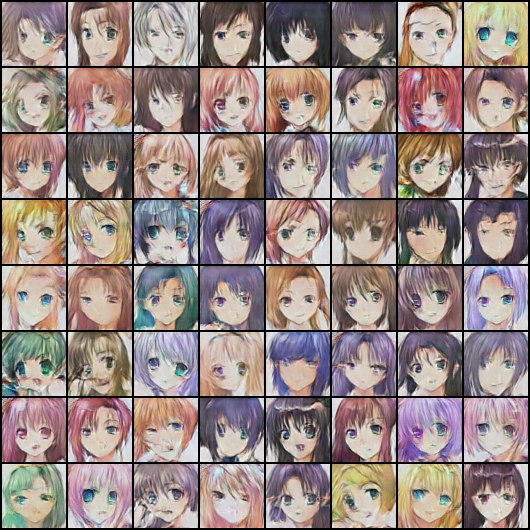

In [ ]:
Image('./generated/generated-images-0020.png')

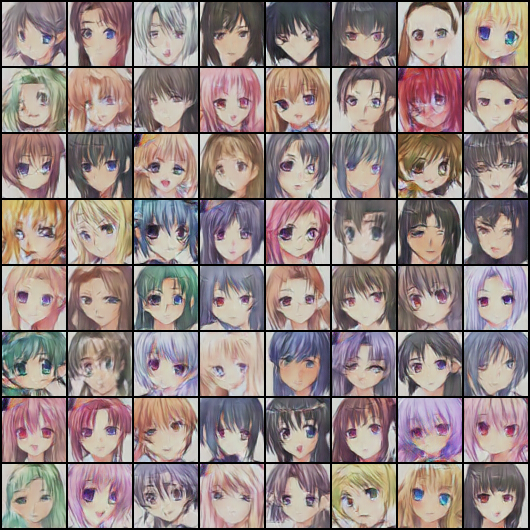

In [ ]:
Image('./generated/generated-images-0030.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

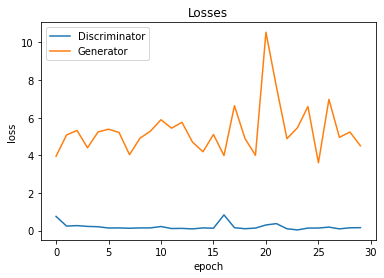

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

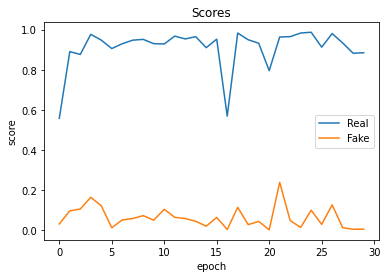

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');